In [1]:
import torch
from torch_geometric.utils import remove_self_loops, coalesce
from GAE import Encoder, Decoder, GAE
from torchinfo import summary
from torch_geometric.data import Data
import numpy as np
import torch.optim as optim
import scipy
import os
import Get_data as Gd
from sklearn.model_selection import train_test_split
import torch.nn as nn

from tqdm import tqdm  
import matplotlib.pyplot as plt

/home/scheng1/miniconda3/envs/wl4023/lib/python3.10/site-packages/torch/cuda/__init__.py:619: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")


In [2]:
# 检查是否有 GPU 可用
if torch.cuda.is_available():
    print("GPU is available")
else:
    print("GPU is not available")

# 检查 GPU 的数量
num_gpus = torch.cuda.device_count()
print(f"Number of GPUs available: {num_gpus}")

# 获取每个 GPU 的名称
for i in range(num_gpus):
    print(f"GPU {i}: {torch.cuda.get_device_name(i)}")

# 设置默认使用的 GPU 设备
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

GPU is not available
Number of GPUs available: 0
Using device: cpu


In [3]:
directory = '/data/Sibo_22Mar2024'
folders = [os.path.join(directory, f, 'hessian_') for f in os.listdir(directory) if f.startswith('case_')]

# Get data

In [4]:
xyfile = "/data/Sibo_22Mar2024/case_0/hessian_/xy_coords.npy"
pos = torch.tensor(np.load(xyfile), dtype=torch.float32)

In [5]:
sparse_graph = scipy.sparse.load_npz('/data/Sibo_22Mar2024/sparse_matrix_fixed.npz')
indices = np.array(sparse_graph.nonzero())
values = sparse_graph.data
shape = sparse_graph.shape

# sparse edge tensor
edge_tensor = torch.sparse_coo_tensor(indices, values, shape, dtype=torch.float).coalesce()
edge_index = edge_tensor.indices()
edge_weight = edge_tensor.values()
print(edge_tensor.shape)
print(edge_index)
print(edge_weight)

torch.Size([97149, 97149])
tensor([[    0,     0,     1,  ..., 97148, 97148, 97148],
        [    1,     3,     0,  ..., 97145, 97146, 97147]])
tensor([1., 1., 1.,  ..., 1., 1., 1.])


In [6]:
lengthscales = [0.17]  # 例如定义的长度比例
num_mp_layers = [2, 3]  # 例如定义的消息传递层数

bounding_box = []
if len(lengthscales) > 0:
    x_lo = pos[:,0].min() - lengthscales[0]/2
    x_hi = pos[:,0].max() + lengthscales[0]/2
    y_lo = pos[:,1].min() - lengthscales[0]/2
    y_hi = pos[:,1].max() + lengthscales[0]/2
    bounding_box = [x_lo.cpu(), x_hi.cpu(), y_lo.cpu(), y_hi.cpu()]

## Train and val data

In [7]:
dataset, length = Gd.get_all_nodes(folders[:-1])

train_np, val_np = train_test_split(dataset, test_size=0.2, shuffle=True)
train_np = np.expand_dims(train_np[:, :, 0], axis=2)
val_np = np.expand_dims(val_np[:, :, 0], axis=2)

In [8]:
train_tensor = torch.tensor(train_np, dtype=torch.float)
train_tensor_set = Gd.MyDataset(train_tensor)
val_tensor = torch.tensor(val_np, dtype=torch.float)
val_tensor_set = Gd.MyDataset(val_tensor)

## Test data

In [9]:
test_np, length = Gd.get_all_nodes(folders[-1:])
test_np = np.expand_dims(test_np[:, :, 0], axis=2)
test_tensor = torch.tensor(test_np, dtype=torch.float)
test_tensor_set = Gd.MyDataset(test_tensor)

In [10]:
print(folders[-1:])

['/data/Sibo_22Mar2024/case_18/hessian_']


# Train

In [11]:
class RMSELoss(nn.Module):
    def __init__(self):
        super(RMSELoss, self).__init__()
        self.mse = nn.MSELoss()

    def forward(self, y_pred, y_true):
        return torch.sqrt(self.mse(y_pred, y_true))

class NRMSE(nn.Module):
    def __init__(self, total_dataset):
        super(NRMSE, self).__init__()
        self.rmse = RMSELoss()
        self.factor = total_dataset.max()-total_dataset.min()

    def forward(self, y_true, y_pred):
        return self.rmse(y_true, y_pred)/self.factor

In [12]:
def train(model, train_set, val_set, edge_index, edge_attr, pos, criterion, optimizer, device, metric_train, metric_val, epochs=30):
    edge_index, edge_attr, pos = edge_index.to(device), edge_attr.to(device), pos.to(device)

    train_NRMSELoss_list = []
    train_RMSELoss_list = []

    val_NRMSELoss_list = []
    val_RMSELoss_list = []

    for i in range(epochs):
        model.train()
        train_loss = 0
        relative_train_loss = 0
        for x in tqdm(train_set):
            x = x.to(device)
            optimizer.zero_grad()
            predict, _, _ = model(x, edge_index, edge_attr, pos)
            # print(predict.max(), predict.min())
            loss = criterion(x, predict)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
            relative_train_loss += metric_train(x, predict).item()

        train_loss = train_loss/len(train_set)
        relative_train_loss /= len(train_set)
        train_RMSELoss_list.append(train_loss)
        train_NRMSELoss_list.append(relative_train_loss)

        model.eval()
        with torch.no_grad():
            val_loss = 0
            relative_val_loss = 0
            for x in val_set:
                x = x.to(device)
                predict, _, _ = model(x, edge_index, edge_attr, pos)
                loss = criterion(x, predict)
                val_loss += loss.item()
                relative_val_loss += metric_val(x, predict).item()


            val_loss /= len(val_set)
            relative_val_loss /= len(val_set)

            val_RMSELoss_list.append(val_loss)
            val_NRMSELoss_list.append(relative_val_loss)

        print(f'Epoch {i + 1}/{epochs}, train Loss: {train_loss}, NRMSE_train_loss: {relative_train_loss}, val Loss: {val_loss}, NRMSE_val_loss: {relative_val_loss}')
        if (len(val_RMSELoss_list) > 1) and (val_RMSELoss_list[-1] <= val_RMSELoss_list[-2]):
            torch.save(model.state_dict(), 'GAE_copy.pth')

    return train_RMSELoss_list, val_RMSELoss_list, train_NRMSELoss_list, val_NRMSELoss_list

In [13]:
model = GAE(1, 1, bounding_box, lengthscales, num_mp_layers, 16, 2)
summary(model, input_data=(train_tensor[0], edge_index, edge_weight, pos))

Layer (type:depth-idx)                             Output Shape              Param #
GAE                                                [97149, 1]                --
├─Encoder: 1-1                                     [49, 16]                  --
│    └─ModuleList: 2-3                             --                        (recursive)
│    │    └─Linear: 3-1                            [97149, 16]               32
│    └─ELU: 2-2                                    [97149, 16]               --
│    └─ModuleList: 2-3                             --                        (recursive)
│    │    └─Linear: 3-2                            [97149, 16]               272
│    └─ELU: 2-4                                    [97149, 16]               --
│    └─ModuleList: 2-15                            --                        (recursive)
│    │    └─ModuleList: 3-4                        --                        (recursive)
│    └─ELU: 2-6                                    [291032, 16]              -

In [14]:
criterion = RMSELoss()
optimizer = optim.Adam(model.parameters())
metric_train = NRMSE(train_tensor)
metric_val = NRMSE(val_tensor)
model.to(device)
train_RMSELoss_list, val_RMSELoss_list, train_NRMSELoss_list, val_NRMSELoss_list = train(model,
                                                                                         train_tensor_set,
                                                                                         val_tensor_set,
                                                                                         edge_index,
                                                                                         edge_weight,
                                                                                         pos,
                                                                                         criterion,
                                                                                         optimizer,
                                                                                         device,
                                                                                         metric_train,
                                                                                         metric_val, 
                                                                                         epochs=50)

  0%|          | 1/2320 [00:00<08:46,  4.40it/s]

  5%|▌         | 116/2320 [00:24<07:51,  4.68it/s]


KeyboardInterrupt: 

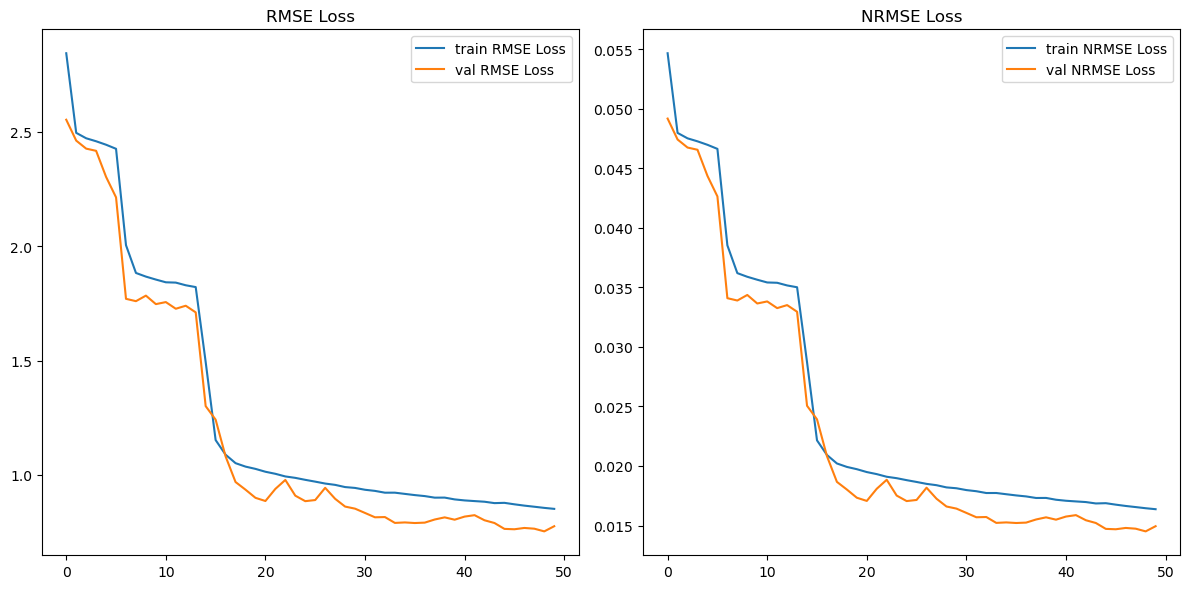

In [ ]:
fig1, axs = plt.subplots(1, 2, figsize=(12, 6))
train_RMSELoss_list, val_RMSELoss_list, train_NRMSELoss_list, val_NRMSELoss_list
axs[0].plot(train_RMSELoss_list, label='train RMSE Loss')
axs[0].plot(val_RMSELoss_list, label='val RMSE Loss')
axs[0].set_title("RMSE Loss")
axs[0].legend()

axs[1].plot(train_NRMSELoss_list, label='train NRMSE Loss')
axs[1].plot(val_NRMSELoss_list, label='val NRMSE Loss')
axs[1].set_title("NRMSE Loss")
axs[1].legend()

plt.tight_layout()  # 调整布局以防止重叠
plt.show()

# Result

In [ ]:
def draw_pic(x, y, coords):
    # 计算所有子图中颜色值的全局最小值和最大值
    vmin = min([x[i].min() for i in range(5)] + [y[i].min() for i in range(5)])
    vmax = max([x[i].max() for i in range(5)] + [y[i].max() for i in range(5)])

    fig1, axs = plt.subplots(1, 5, figsize=(30, 6), sharey=True)
    for i in range(5):
        im = axs[i].scatter(coords[:, 0], coords[:, 1], s=5, c=x[i], cmap='bwr', vmin=vmin, vmax=vmax)
        axs[i].set_title('input')
    fig1.colorbar(im, ax=axs.ravel().tolist(), orientation='vertical')
    plt.show()
    plt.close()

    fig2, axs = plt.subplots(1, 5, figsize=(30, 6), sharey=True)
    for i in range(5):
        im = axs[i].scatter(coords[:, 0], coords[:, 1], s=5, c=y[i], cmap='bwr', vmin=vmin, vmax=vmax)
        axs[i].set_title('recon')
    fig2.colorbar(im, ax=axs.ravel().tolist(), orientation='vertical')
    plt.show()
    plt.close()

# 示例使用方式
# x = [np.random.randn(100) for _ in range(5)]
# y = [np.random.randn(100) for _ in range(5)]
# coords = np.random.randn(100, 2)
# draw_pic(x, y, coords)


In [ ]:
gae = GAE(1, 1, bounding_box, lengthscales, num_mp_layers, 16, 2)
criterion = RMSELoss()
metric = NRMSE(test_tensor)
# 加载保存的状态字典
state_dict = torch.load('GAE.pth')
gae.load_state_dict(state_dict)

1 16
16 1
1 16
16 1


<All keys matched successfully>

In [ ]:
gae.eval()
y = torch.zeros_like(test_tensor)
test_RMSE_Loss = []
test_NRMSE_Loss = []
with torch.no_grad():
    ave_rmse = 0
    ave_nrmse = 0
    for i in range(len(test_tensor)):
        y[i], _, _ = gae(test_tensor[i], edge_index, edge_weight, pos)
        rmse = criterion(test_tensor[i], y[i]).item()
        nrmse = metric(test_tensor[i], y[i]).item()

        test_RMSE_Loss.append(rmse)
        test_NRMSE_Loss.append(nrmse)

        ave_rmse += rmse
        ave_nrmse += nrmse

ave_rmse /= len(test_tensor)
ave_nrmse /= len(test_tensor)


print(f"RMSE loss: {ave_rmse}")
print(f"NRMSE loss: {ave_nrmse}")
    

RMSE loss: 1.4776051092147826
NRMSE loss: 0.03448804283514619


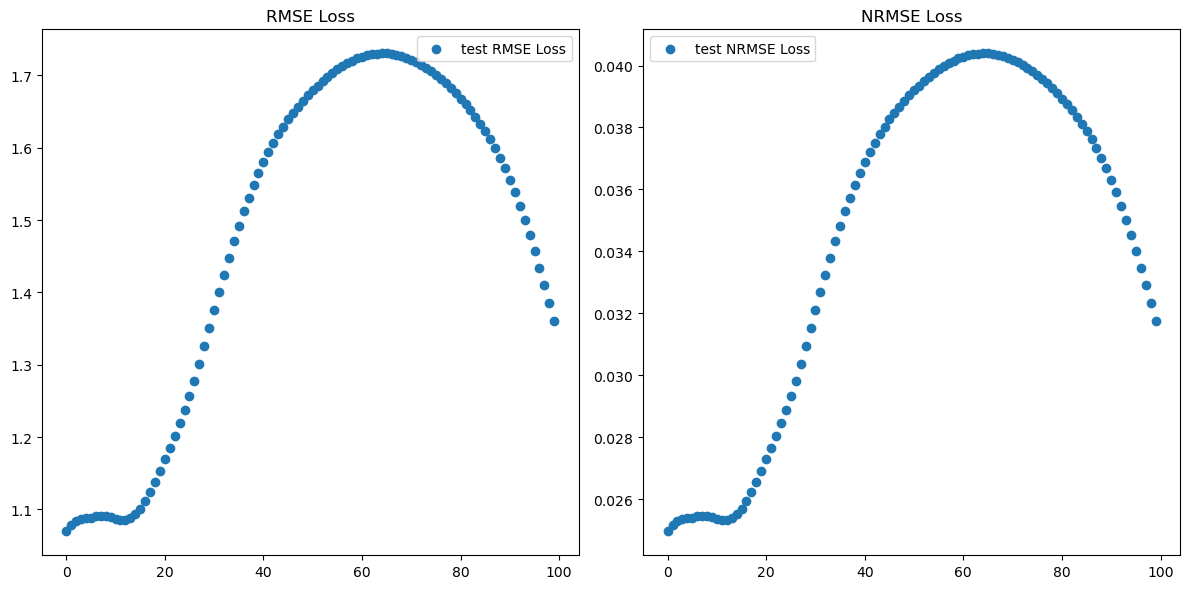

In [ ]:
test_RMSE_Loss = np.array(test_RMSE_Loss)
test_NRMSE_Loss = np.array(test_NRMSE_Loss)

# 保存数组到 .npy 文件
np.save('test_rmse.npy', test_RMSE_Loss)
np.save('test_nrmse.npy', test_NRMSE_Loss)


fig1, axs = plt.subplots(1, 2, figsize=(12, 6))

x = np.arange(0, 100)

axs[0].scatter(x, test_RMSE_Loss, label='test RMSE Loss')
axs[0].set_title("RMSE Loss")
axs[0].legend()

axs[1].scatter(x, test_NRMSE_Loss, label='test NRMSE Loss')
axs[1].set_title("NRMSE Loss")
axs[1].legend()


plt.tight_layout()  # 调整布局以防止重叠
plt.show()

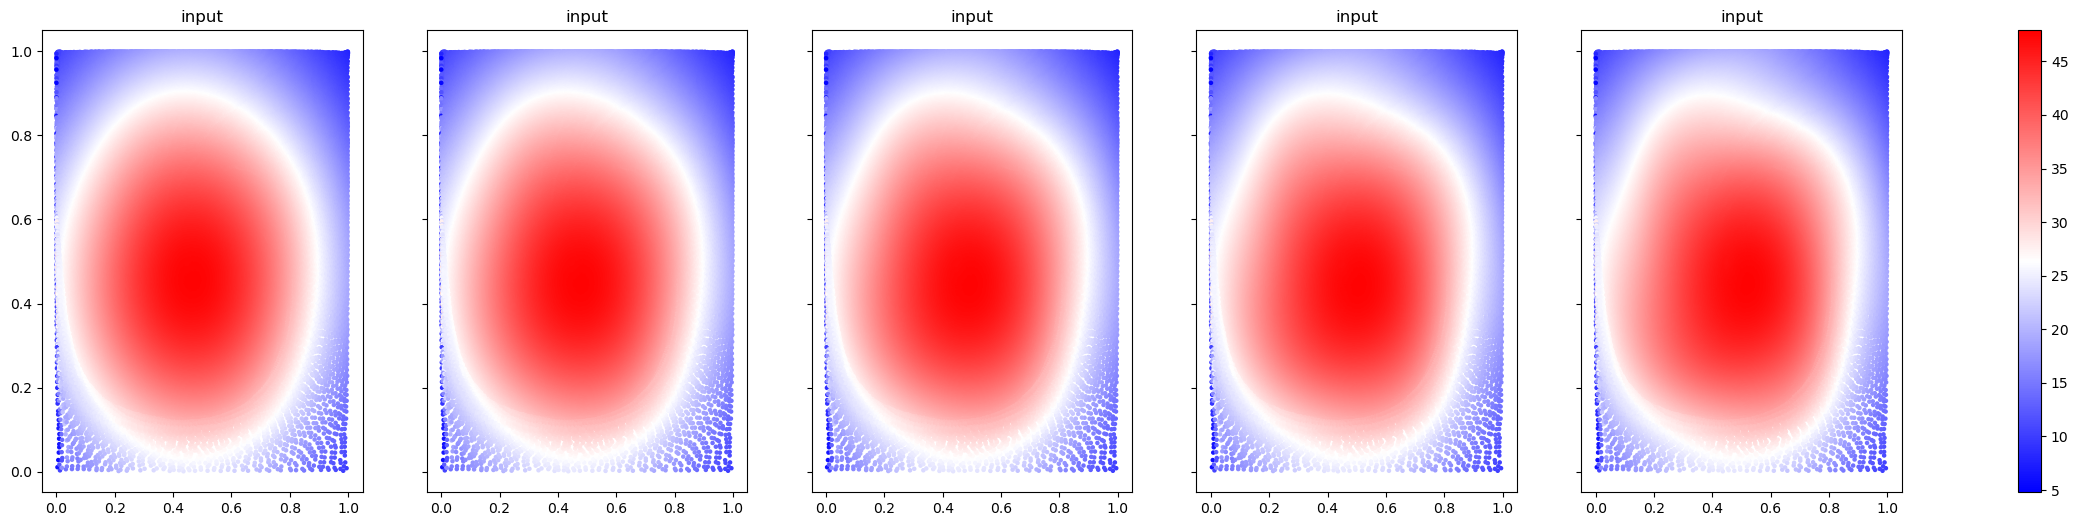

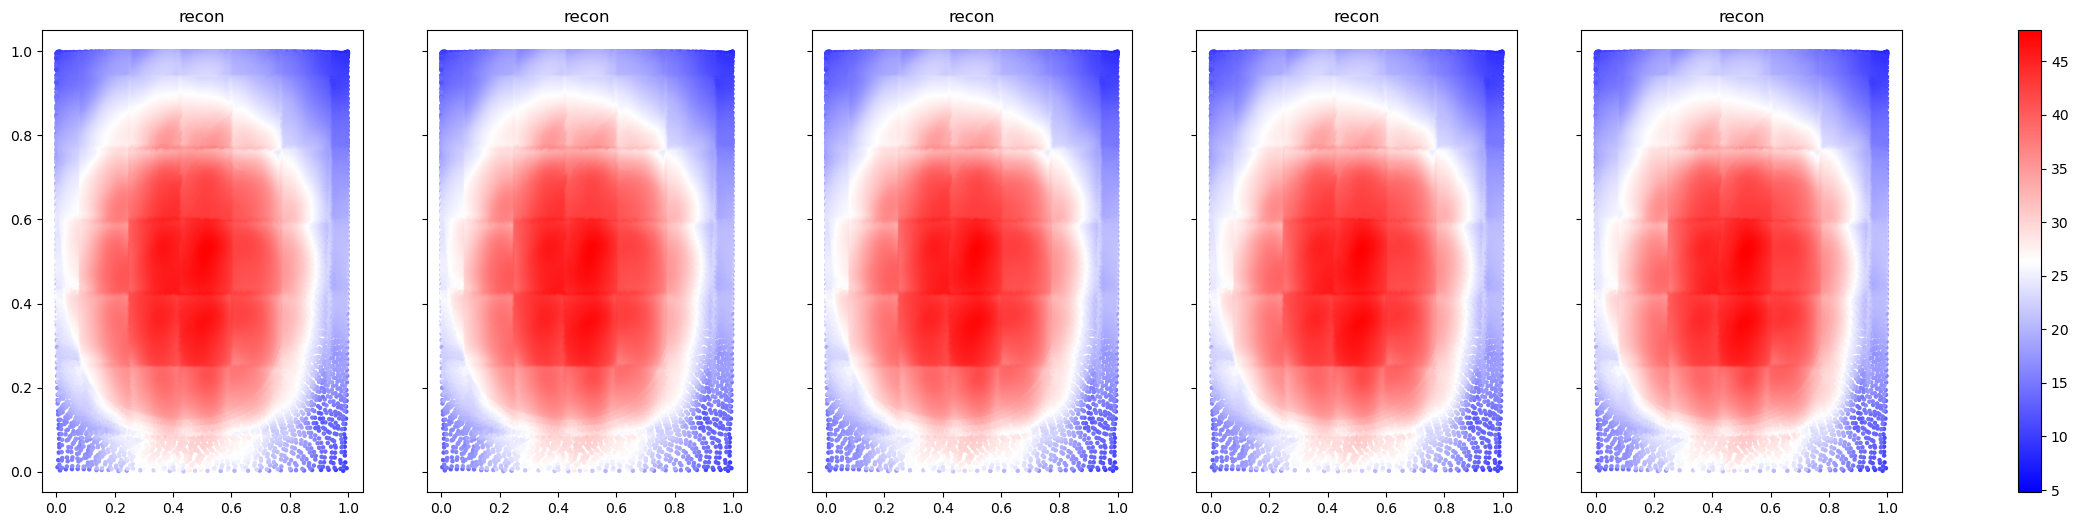

In [ ]:
x = test_tensor_set[:5]
recon_x = y[:5]


x_np = x.cpu().detach().numpy()
recon_x_np = recon_x.cpu().detach().numpy()
pos_np = pos.cpu().detach().numpy()
draw_pic(x_np, recon_x_np, pos_np)